# Mathematic Majors Student Data

Exploring data on students who graduated between the 13-14 and 17-18 academic years with a major in mathematics from Union College. Particularly interested in identifying insights that might improve the student experience. Need to be wary of potential confounding factors. Additionally, interpretation is affect by the data not including; math majors who have yet to graduate, math minors or other students taking math courses.

## Set up the notebook environment

In [1]:
# Imports
from IPython.display import HTML 
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
# Settings
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (6.0, 6.0)
pd.set_option('max_rows', 7)
pd.set_option('max_columns', 50)

In [3]:
# Constants
datafile = 'data/union_students_818.xlsx'

# Grades rank order
grade_to_point = {'A':4.0, 'A-':3.7, 'B+':3.3, 'B':3.0, 'B-':2.7, 'C+':2.3,
                  'C':2.0, 'C-':1.7, 'D': 1.0, 'F':0.0, 'NC': None, 'P': None}
grade_rank = ['A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D', 'F']
point_rank = [grade_to_point[grade] for grade in grade_rank]

# Terms - quarters
term_to_month = {'FA':9, 'WI':1, 'SP':4, 'SU':7}
term_order_nosu = ['FA', 'WI', 'SP']

# Course groups
#   Somewhat arbitrary groups based on major requirements:
#         https://muse.union.edu/mathematics/program/major-minor/
#   note: intro courses split into three paths and may also be satisified 
#         with AP credit, first path (MTH-100 -101, -102) excluded as it is
#         uncommon for majors
#   note: 497 or 498 and 499 are senior theses. P (pass) is give to 498
#         instead of a letter grade
courses_intro = ['MTH-110', 'MTH-112','MTH-113']
courses_core = ['MTH-115', 'MTH-115H', 'MTH-117', 'MTH-199', 'MTH-332', 
                'MTH-336', 'MTH-340']
courses_thesis = ['MTH-497', 'MTH-499']
courses_select = courses_intro + courses_core + courses_thesis

In [4]:
# Optional switch to use simplified data for troubleshooting and testing
if False:
    datafile = 'data/dummy_data.xlsx'
    courses_select = ['MTH-1', 'MTH-2', 'MTH-3', 'MTH-4', 'MTH-5']

## Load and clean the data

In [5]:
# Load student info data from excel file
info = pd.read_excel(datafile, sheet_name='student info')

# Column name style preferences
info.columns = map(str.lower, info.columns)
info.rename({'@id':'id',
             'class - not grad year necessarily':'class_year',
             'total giving':'giving',
             'greek affilation':'greek',
             'student interest 1':'interest_1',
             'student interest 2':'interest_2',
             'student interest 3':'interest_3',
             'student interest 4':'interest_4',
             'student interest5':'interest_5',
             'student interest6':'interest_6',
             'home addr1':'home_address',
             'home city':'home_city',
             'home st':'home_state',
             'left without graduating?':'left_wo_grad'
            }, axis=1, inplace=True)

# De-identify ids
#   Reassign student ids to unknown student-id pairings.
unique_ids = info['id'].unique()
np.random.shuffle(unique_ids)
new_ids = {unique_id:idx + 1 for idx, unique_id in enumerate(unique_ids)}
info['id'] = info.apply(lambda srs: new_ids[srs['id']], axis=1)

# Drop names
info.drop(['first', 'last'], axis=1, inplace=True)

print('Student info columns: {0}'
      .format(', '.join([col for col in info.columns])))

Student info columns: id, class_year, giving, greek, interest_1, interest_2, interest_3, interest_4, interest_5, interest_6, employer, title, home_address, home_city, home_state, left_wo_grad


In [6]:
# Load grades data from excel file
data = pd.read_excel(datafile, sheet_name='psa.grad.grades')

# Column name style preferences
data.columns = map(str.lower, data.columns)
data.rename({'acad major':'major'}, axis=1, inplace=True)

# Drop duplicate rows
data.drop_duplicates(inplace=True)

# Ignore summer term (per email)
# display(data.loc[data.term.str.match('.*/SU')])  # view dropped summer data
data.drop(data.loc[data.term.str.match('.*/SU')].index, inplace=True)

# Add year column and reassign term to season only
data['year'] = data['term'].map(lambda srs: int('20' + srs.split('/')[0]))
data['term'] = data['term'].map(lambda srs: srs.split('/')[1])

# Derive grade point and date columns
data['point'] = data['grade'].map(lambda grade: grade_to_point[grade])
data['date'] = (data.apply(lambda srs:pd.to_datetime('{0}/01/{1}'
                                   .format(term_to_month[srs.term], srs.year)),
                           axis=1))

# Use de-identifies ids
data['id'] = data.apply(lambda srs: new_ids[srs['id']], axis=1)

# Store columns of interest in desired order
data = data.loc[:, ['id', 'major', 'course', 'faculty', 'term', 'year', 'date',
                    'grade', 'point']]

print('Student grades data sample:')
data

Student grades data sample:


,id,major,course,faculty,term,year,date,grade,point
0,5,MT,MTH-110,"Friedman, P.",FA,2014,2014-09-01,C+,2.3
1,5,MT,MTH-199,"Cervone, D.",FA,2015,2015-09-01,C+,2.3
2,5,MT,MTH-115,"Barbanel, J.",SP,2015,2015-04-01,B,3.0
...,...,...,...,...,...,...,...,...,...
1337,64,BMTPY,MTH-340,"Zwicker, W.",WI,2015,2015-01-01,A-,3.7
1338,64,BMTPY,MTH-117,"Todd, G.",SP,2016,2016-04-01,A,4.0
1339,64,BMTPY,MTH-497,"Wang, J.",WI,2016,2016-01-01,A,4.0


In [7]:
# Add GPA to info
info = info.merge(data.groupby('id')
                      .point.agg('mean')
                      .to_frame(name='gpa').reset_index(), 
                  on='id')

## Data exploration

### Counting things

To get a feel for the data and see if anything looks interesting

#### Number of students

In [8]:
# Unique students
info_num_students = len(info.id.unique())
grade_num_students = len(data.id.unique())
print('Total number of students in the student info data = {0}'
      .format(info_num_students))
print('Total number of students in the student grades data = {0}'
      .format(grade_num_students))
print()
print('Number of students who left without graduating = {0}'
      .format(len(info.loc[info.left_wo_grad == 'Y'])))

Total number of students in the student info data = 110
Total number of students in the student grades data = 110

Number of students who left without graduating = 1


#### Student majors

It looks like each students major(s) are encoded as a single string. With the key this section might be rewritten to break down code by major which could be more useful going forward. 

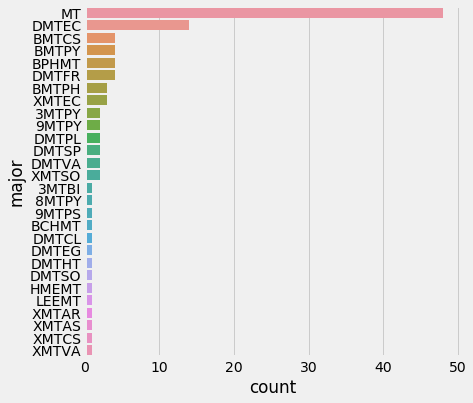

In [9]:
# Students by major
ax = sns.barplot(y='major', x='count', 
            data=(data
                  .groupby('id').apply(lambda group: group.major.unique()[0])
                  .value_counts()
                  .to_frame(name='count')
                  .reset_index()
                  .rename(columns={'index':'major'})
                  .sort_values(['count', 'major'], ascending=[False, True])
                 )
           )

plt.show()

#### Number of times each faculty appears in the data
* The same student taking the same professor multiple times counts each time.
* Remember data does not include minors or non-majors, so not a reflection of how many total students were taught by professor


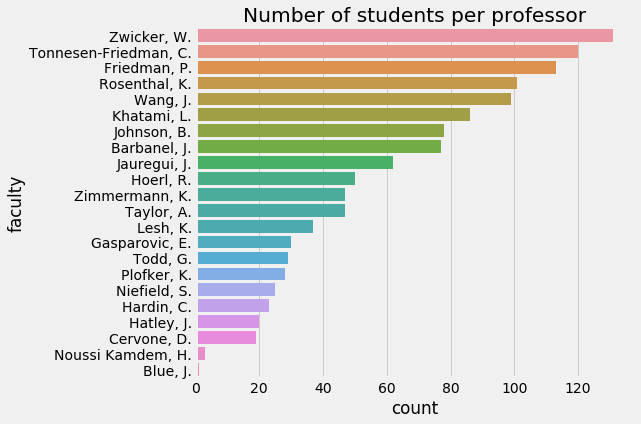

In [10]:
# Faculty counts
plt.figure(figsize=(7.0, 6.0))
sns.countplot(y='faculty', data=data, order=data.faculty.value_counts().index)
plt.title('Number of students per professor')
plt.show()

#### Student class (year)
* Labeled as "class - not grad year necessarily", not sure how this is defined, but probably explains students from 2010, 2013 and 2019 classes. 

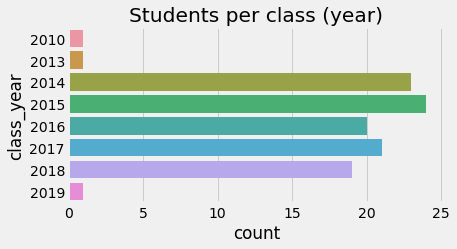

In [11]:
# Class year
plt.figure(figsize=(6.0, 3.0))
sns.countplot(y='class_year', data=info, order=info.class_year.unique().sort())
plt.title('Students per class (year)')
plt.show()

#### Greek affiliations

Most students unaffiliated. Might be recast as unaffiliated vs. affiliated if looking for correlations.

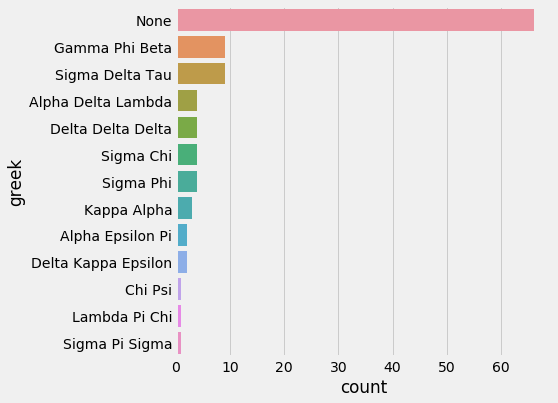

Number of students with a Greek affiliation = 44
Number of students without a Greek affiliation = 66


In [12]:
# Greek affiliations
ax = sns.barplot(y='greek', x='count', 
                 data=(info
                       .fillna('None')
                       .greek
                       .value_counts()
                       .to_frame(name='count')
                       .reset_index()
                       .rename(columns={'index':'greek'})
                       .sort_values(['count', 'greek'], ascending=[False, True])
                      )
                )

plt.show()

print('Number of students with a Greek affiliation = {0}'
      .format(info.greek.notnull().sum()))
print('Number of students without a Greek affiliation = {0}'
      .format(info.greek.isnull().sum()))

#### Students interests

* Combined all six interest columns and excluded Na for counts. 
* Most interests were expressed by only a few students, but a few many be large enough to look for correlations. 
* Some interests might be grouped (i.e. different Houses, Greek affiliations).

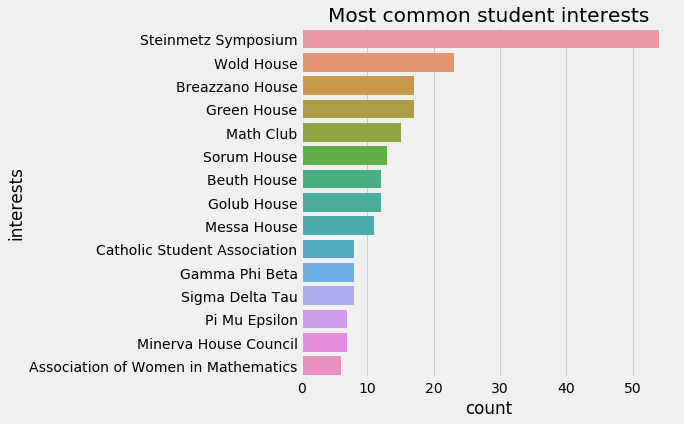

In [13]:
# Students interests count
interest_data = (info.loc[:, 'interest_1':'interest_6']
                 .stack().to_frame(name='interests'))

sns.countplot(y='interests', data=interest_data,
              order=(interest_data.interests.value_counts().index)[:15])
plt.title('Most common student interests')
plt.show()

#### Employers and job titles

* As is, these are very specific to each student. 
  + Each company only employs a single student
  + Only a few students share exact same job titles
<br><br>
* However they could be grouped if someone were to assign membership
  + i.e. Employers might be grouped by business sector
  + i.e. Titles like 'Teacher' and 'Middle School Teacher' could be combined into 'Teaching'
<br><br>  
* Missing information on students who went to graduate school

In [14]:
# Most common employers
if (info.employer.value_counts() > 1).any():
    print('Most common employers:')
    display(info.employer.value_counts().sort_values(ascending=False)[:5]
            .to_frame(name='count'))
else:
    print('No two students employed by same company')
    
# # List of all employers
# print()
# print('\n'.join([employer.replace(',','') for employer in 
#                  info.loc[info.employer.notnull()]
#                      .employer.sort_values().unique()]))

No two students employed by same company


In [15]:
# Most common titles
if (info.title.value_counts() > 1).any():
    print('Most common titles:')
    display(info.title.value_counts().loc[info.title.value_counts() > 1]
            .to_frame(name='count')[:5])
else:
    print('No two students with the exact same job title')
    
# # List of all titles
# print('\n'.join([title.replace(',','') for title in 
#                 info.loc[info.title.notnull()].title.sort_values().unique()]))

Most common titles:


,count
Analyst,3
Software Developer,2


#### Number of times each course was taken

Some courses taken only a few or even a single time by majors in the give data.

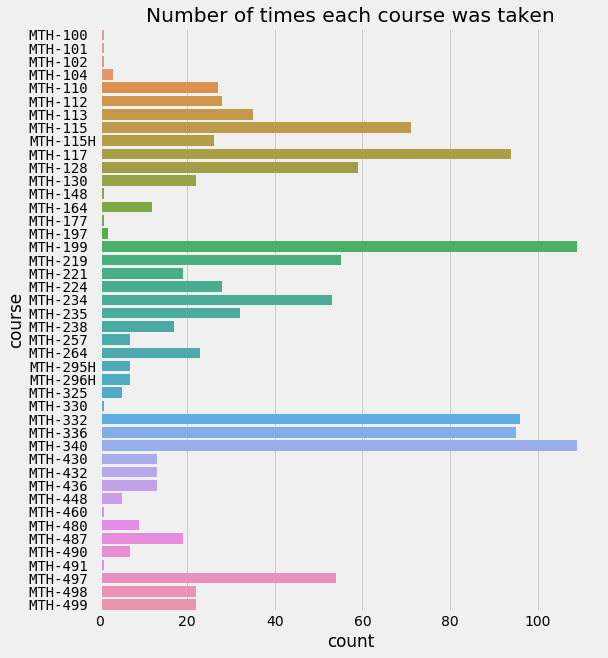

In [16]:
# Courses taken
min_count = 1   # exclude courses taken less than min_count times
graph_data = (data
              # hack for left aligned tick labels, pad + use monospace font
              .assign(course = lambda srs: srs.course.str.pad(8, 'right'))
              .groupby('course').filter(lambda group: len(group) >= min_count)
             )

plt.figure(figsize=(8.0, 10.0))
ax = sns.countplot(y='course', 
              data=graph_data,
              order=sorted(graph_data.course.unique())   # By course number 
              #order=graph_data.course.value_counts().index    # By count
             )

for tick in ax.get_yticklabels():
    tick.set_fontname('DejaVu Sans Mono')

plt.title('Number of times each course was taken')
plt.show()

#### Grades

The number of times each letter grade was given combined across all courses. Looks like math majors tend to do well in math courses. Not too surprising.

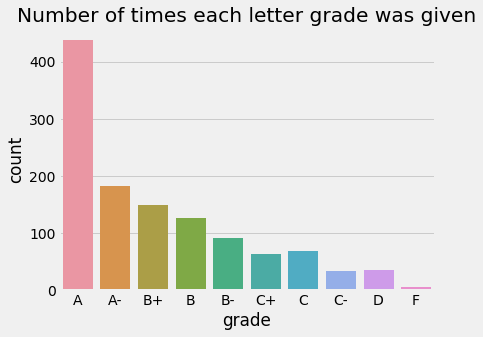

In [17]:
# Grades
plt.figure(figsize=(6.0, 4.5))
sns.countplot(x='grade', data=data, order=grade_rank)
plt.title('Number of times each letter grade was given')
plt.show()

### Grades by term (Fall / Winter / Spring)

* Investigating if the term affects the distribution of grades.
  + It doesn't look like that's the case here.

In [18]:
# Counts of letter grade by term
print('Count by term:')
display(data.pivot_table('id', 'term', 'grade', aggfunc='count')
            .loc[term_order_nosu, :]
            .reindex(columns=grade_rank + ['P'], fill_value=0))

print('Percentage by term (not including "P"):')
with pd.option_context('display.float_format', '{:,.1f}'.format):
    display(data
            .drop(data.loc[data.grade == 'P'].index)
            .pivot_table('id', 'term', 'grade', aggfunc=len)
            .apply(lambda srs: srs / sum(srs) * 100, axis=1)
            .loc[term_order_nosu, :]
            .reindex(columns=grade_rank, fill_value=0.0)
           )

Count by term:


grade,A,A-,B+,B,B-,C+,C,C-,D,F,P
term,,,,,,,,,,,
FA,135,66,55,39,27,18,27,8,14,2,24
WI,165,62,51,46,25,24,24,12,11,1,7
SP,137,55,44,41,39,22,17,13,10,3,2


Percentage by term (not including "P"):


grade,A,A-,B+,B,B-,C+,C,C-,D,F
term,,,,,,,,,,
FA,34.5,16.9,14.1,10.0,6.9,4.6,6.9,2.0,3.6,0.5
WI,39.2,14.7,12.1,10.9,5.9,5.7,5.7,2.9,2.6,0.2
SP,36.0,14.4,11.5,10.8,10.2,5.8,4.5,3.4,2.6,0.8


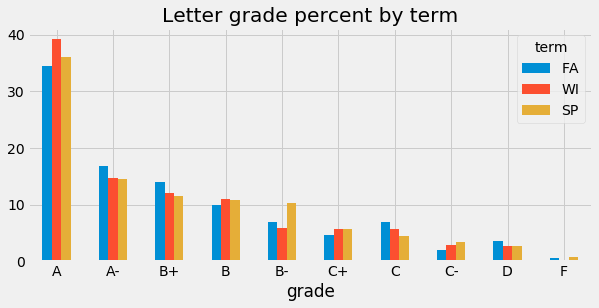

In [19]:
# Letter grade by term as percentage of grades from that term
(data
 .drop(data.loc[data.grade == 'P'].index)
 .pivot_table('id', 'term', 'grade', aggfunc=len)
 .loc[term_order_nosu, :]
 .reindex(columns=grade_rank, fill_value=0.0)
 .apply(lambda srs: srs / sum(srs) * 100, axis=1)).T.plot.bar(figsize=(9, 4))
plt.title('Letter grade percent by term')
plt.xticks(rotation=0)
plt.show()

In [20]:
# Grade point by term summary statistics
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(data.groupby('term').point.agg('describe')
           .loc[term_order_nosu])

,count,mean,std,min,25%,50%,75%,max
term,,,,,,,,
FA,391.00,3.27,0.83,0.00,3.00,3.70,4.00,4.00
WI,421.00,3.32,0.80,0.00,3.00,3.70,4.00,4.00
SP,381.00,3.26,0.83,0.00,2.70,3.70,4.00,4.00


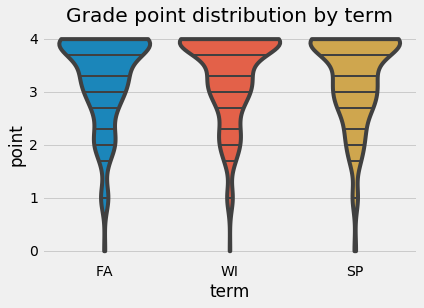

In [21]:
# Grade point by term distribution
plt.figure(figsize=(6, 4))
sns.violinplot(x='term', y='point', data=data, order=term_order_nosu,
               inner='sticks', scale='area', cut=0)
plt.title('Grade point distribution by term')
plt.show()

### Grade point by course

* Investigating how the distribution of grades varies by course
  + Only looking at subset of courses selected based on major requirements 
    * Just to save space, could be extended to cover more courses.
<br><br>
* Only a single individual followed the MTH-100, MTH-101, MTH-102 path
  + So only a single A was give in these and 100% of the grades where "A"s
  + Probably need to exclude from future analysis
<br><br>
* MTH-113 students received lower grades on average than those on the MTH-110 MTH-112 option.
* MTH-115H students received higher grades on average than MTH-115.
  + Likely this reflects why they took the honors course and not the course difficulty

In [22]:
# Counts and percent of letter grade by course as tables
display_tables = False
if display_tables:
    print('Count by course:')
    with pd.option_context('display.float_format', '{:,.0f}'.format,
                           'max_rows', 15):
        display(data.pivot_table('id', 'course', 'grade', aggfunc='count')
                .loc[courses_select, :]
                .reindex(columns=grade_rank + ['P'], fill_value=0)
                .fillna(0)
           )

    print('Percentage by course (not including "P"):')
    with pd.option_context('display.float_format', '{:,.1f}'.format,
                           'max_rows', 15):
        display(data
                .drop(data.loc[data.grade == 'P'].index)
                .loc[data.course.isin(courses_select)]
                .pivot_table('id', 'course', 'grade', aggfunc='count', fill_value=0)
                .apply(lambda srs: srs / sum(srs) * 100, axis=1)
                .reindex(columns=grade_rank, fill_value=0.0)
          )

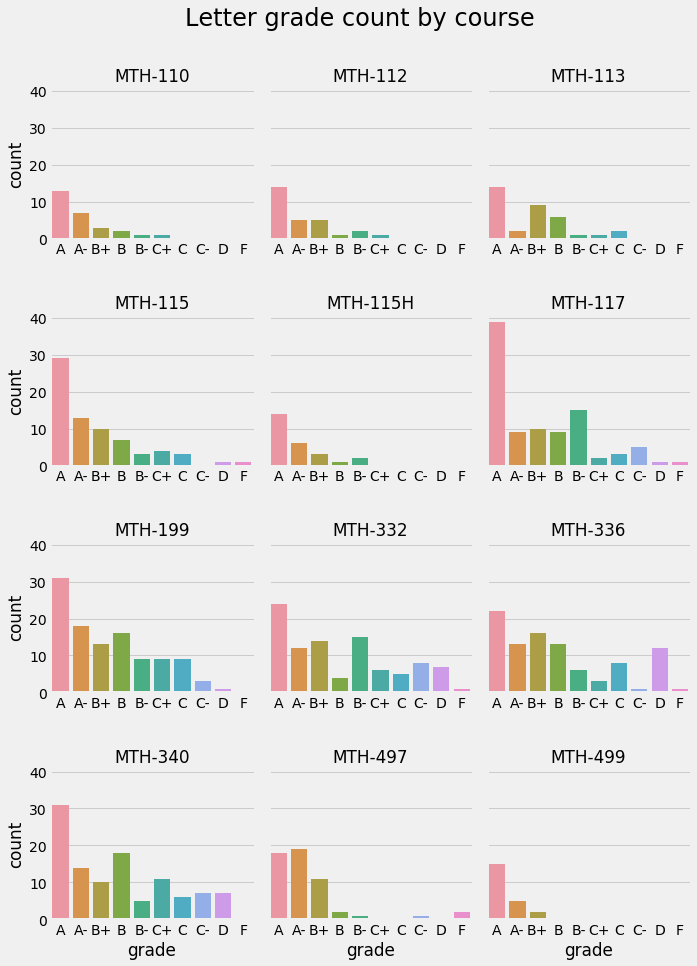

In [23]:
# Graph count of letter grade by course 
def mini_countplot(x, order, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    sns.countplot(x=x, data=data, order=order, ax=ax)
    
g = sns.FacetGrid(data.loc[data.course.isin(courses_select)],
                  col='course', col_wrap=3, height=3.2,
                  col_order=courses_select,
                  sharex=False)

g = (g.map_dataframe(mini_countplot, 'grade', order=grade_rank, data=data)
     .set_titles('{col_name}')
     .set_axis_labels('grade', 'count')
     .fig.subplots_adjust(hspace=0.5))

plt.suptitle('Letter grade count by course', y=1.05, fontsize=24)
plt.show()

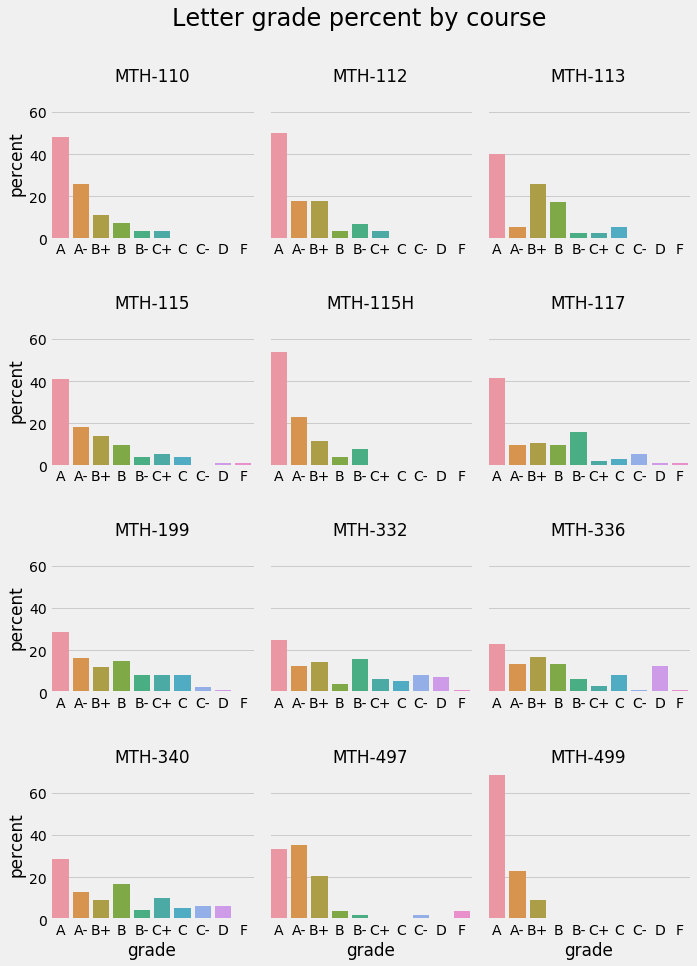

In [24]:
# Graph percent of letter grade by course
def mini_barplot(x, order, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    sns.barplot(y='percent', x='grade', 
                data=((data[x].value_counts(normalize=True) * 100)
                      .reset_index()
                      .rename({'grade':'percent', 'index':'grade'}, axis=1)),
                order=grade_rank)
    
g = sns.FacetGrid(data.loc[data.course.isin(courses_select)],
                  col='course', col_wrap=3, height=3.2,
                  col_order=courses_select,
                  sharex=False)

g = (g.map_dataframe(mini_barplot, 'grade', order=grade_rank, data=data)
     .set_titles('{col_name}')
     .set_axis_labels('grade', 'percent')
     .fig.subplots_adjust(hspace=0.5)
    )

plt.suptitle('Letter grade percent by course', y=1.05, fontsize=24)
plt.show()

In [25]:
# Grade point by course
with pd.option_context('display.float_format', '{:,.2f}'.format,
                       'max_rows', 15):
    display(data
            .loc[data.course.isin(courses_select)]
            .groupby('course')
            .point.agg('describe'))

,count,mean,std,min,25%,50%,75%,max
course,,,,,,,,
MTH-110,27.00,3.66,0.46,2.30,3.50,3.70,4.00,4.00
MTH-112,28.00,3.63,0.49,2.30,3.30,3.85,4.00,4.00
MTH-113,35.00,3.43,0.59,2.00,3.00,3.30,4.00,4.00
MTH-115,71.00,3.41,0.78,0.00,3.00,3.70,4.00,4.00
MTH-115H,26.00,3.71,0.41,2.70,3.70,4.00,4.00,4.00
MTH-117,94.00,3.30,0.82,0.00,2.70,3.70,4.00,4.00
MTH-199,109.00,3.22,0.74,1.00,2.70,3.30,4.00,4.00
MTH-332,96.00,2.95,0.98,0.00,2.30,3.30,3.78,4.00
MTH-336,95.00,2.95,1.02,0.00,2.30,3.30,3.70,4.00


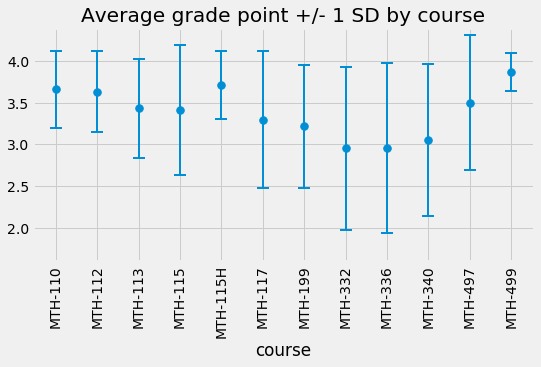

In [26]:
# Grade point by course - mean and SD
(data
 .loc[data.course.isin(courses_select)]
 .groupby('course')
 .point.agg(['mean', 'std'])
 .reset_index()
 .plot('course', 'mean',
       yerr='std', elinewidth=2, capsize=6, capthick=2,
       linestyle='None', marker='.', markersize=15,
       figsize=(8, 4),
       ylim=(1.6, 4.4),
       legend=None
      )
)
plt.xticks(np.arange(len(courses_select)), courses_select, rotation='vertical')
plt.title('Average grade point +/- 1 SD by course')
plt.show()

### Grade point by year

* Grade point appears, probably falsely, to decrease slightly over time 
  + Most recent grades dominated by more advanced courses (i.e. no one taking intro classes in 2018 is likely to have graduated yet).
  + Oldest grades dominated by intro courses and have fewer observations
    * Years 2006, 2007, 2008 and 2009 have 4 total observations between them

In [27]:
# Grade point by year summary statistics
with pd.option_context('display.float_format', '{:,.2f}'.format,
                       'max_rows', 12):
    display(data.groupby('year').point.agg('describe'))

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2006,1.00,4.00,nan,4.00,4.00,4.00,4.00,4.00
2007,1.00,4.00,nan,4.00,4.00,4.00,4.00,4.00
2008,2.00,4.00,0.00,4.00,4.00,4.00,4.00,4.00
2010,22.00,3.38,0.54,2.00,3.00,3.30,3.92,4.00
2011,77.00,3.47,0.62,2.00,3.30,3.70,4.00,4.00
2012,137.00,3.39,0.73,0.00,3.00,3.70,4.00,4.00
2013,211.00,3.37,0.71,1.00,3.00,3.70,4.00,4.00
2014,240.00,3.33,0.82,0.00,2.92,3.70,4.00,4.00
2015,212.00,3.15,0.95,0.00,2.70,3.30,4.00,4.00


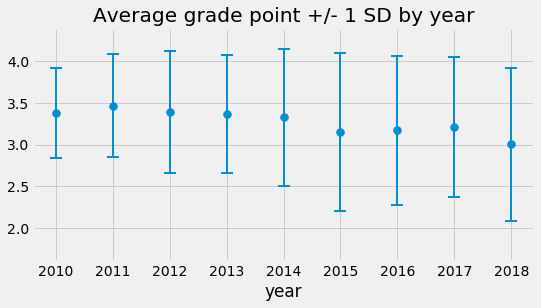

In [28]:
# Grade point by year - mean and SD
(data
 .loc[data['year'] > 2009]
 .groupby('year')
 .point.agg(['mean', 'std'])
 .reset_index()
 .plot('year', 'mean',
       yerr='std', elinewidth=2, capsize=6, capthick=2,
       linestyle='None', marker='.', markersize=15,
       figsize=(8, 4),
       ylim=(1.6, 4.4),
       legend=None
      )
)
plt.title('Average grade point +/- 1 SD by year')
plt.show()

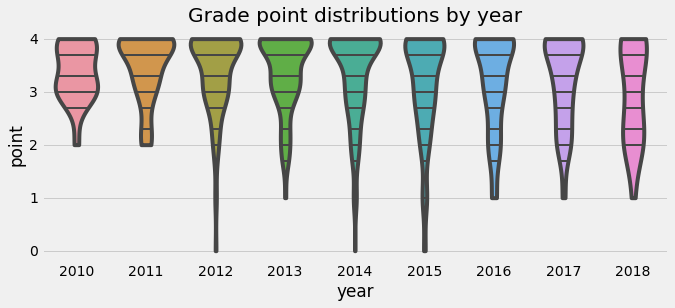

In [29]:
# Grade point by year distribution
plt.figure(figsize=(10, 4))
sns.violinplot(x='year', y='point',
               data=data.loc[data['year'] > 2009],
               inner='sticks',
               scale='area',     #  Each bin has same area
               # scale='count',  #  Bin width scaled by number of observations
               cut=0)
plt.title('Grade point distributions by year')
plt.show()

### GPA by group analyses

#### Greek Affiliation

* Students without a Greek affiliation had slightly better GPAs in this data, however;
  + The effect was not statistical significant (p=0.15)
  + The effect was small (Cohen's d = 0.28)

In [30]:
# Group GPA by Greek affiliation
greek_no_gpa = info.loc[info.greek.isnull()].gpa
greek_yes_gpa = info.loc[info.greek.notnull()].gpa

# Mean and standard deviation of groups
greek_no = (greek_no_gpa.agg(['count', 'mean', 'std']))
greek_yes = (greek_yes_gpa.agg(['count', 'mean', 'std']))
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(pd.DataFrame([greek_yes[['mean', 'std']],
                          greek_no[['mean', 'std']]], 
                 index=['Greek affiliation', 'No Greek affiliation']))

# T-test for independence
_, p_value = stats.ttest_ind(greek_no_gpa, greek_yes_gpa, equal_var=False)

print('t-test p-value = {0:.2f}'.format(p_value))
print()

# Effect size
s_pooled = np.sqrt((((greek_no['count'] - 1) * greek_no['std'] ** 2) +
                    ((greek_yes['count'] - 1) * greek_yes['std'] ** 2)) /
                   (greek_no['count'] + greek_yes['count'] - 2))

cohen_d = np.abs(greek_no['mean'] - greek_yes['mean']) / s_pooled
print("Cohen's d = {0:.2f}".format(cohen_d))


common_lang = stats.norm.cdf((greek_no['mean'] - greek_yes['mean']) / 
                               np.sqrt(greek_no['std'] ** 2 + 
                                       greek_yes['std'] ** 2))

print()
print('Common language effect size = {0:.1f}%'.format(common_lang * 100))
print('(The probability that a student randomly selected from those with no'
      ' Greek affiliation has a higher gpa than a student randomly selected'
      ' from those with a Greek affiliation is {0:.1f}%)'
      .format(common_lang * 100))

,mean,std
Greek affiliation,3.18,0.60
No Greek affiliation,3.35,0.57


t-test p-value = 0.15

Cohen's d = 0.28

Common language effect size = 57.9%
(The probability that a student randomly selected from those with no Greek affiliation has a higher gpa than a student randomly selected from those with a Greek affiliation is 57.9%)


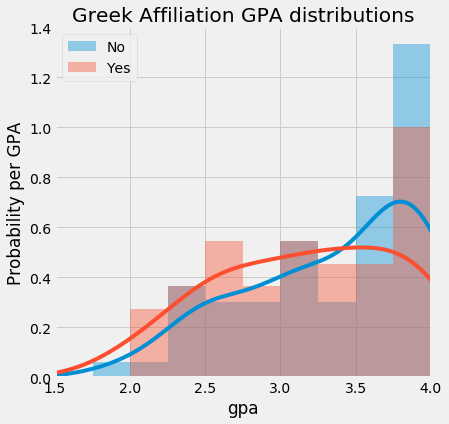

In [31]:
# Greek affiliation (yes vs. no) distributions 
bins = np.arange(1, 4.1, 0.25)
ax = sns.distplot(info.loc[info.greek.isnull()].gpa, bins=bins, label='No')
sns.distplot(info.loc[info.greek.notnull()].gpa, bins=bins, label='Yes')
plt.xlim(1.5, 4)
plt.legend()
plt.ylabel('Probability per GPA')
plt.title('Greek Affiliation GPA distributions')
plt.show()

### Grade point correlations

* Some course combinations were infrequently or never observed
  + Currently calculating correlations for combinations that occur more that 20 times and otherwise leaving cells blank.
<br><br>
* Many strong correlations observed
  + Not surprising that past performance is indicative of future performance
  + Though correlations (a students performance can change course to course)
<br><br>  
* Fair amount of variance in correlations observed
  + Not sure how much of this is noise (sample size is still small)
  + Possibly some is due to courses with tighter grade distributions have less chance to be correlated
  + Possibly courses with more in common are more highly correlated
<br><br>
* No negative correlations were observed
  + Also not surprising, but might have been interesting

In [32]:
# Highest correlations
min_periods = 20

corr_data = (data.groupby('course')
                 .filter(lambda group: len(group) >= min_count)
                 .pivot_table('point', 'id', 'course', aggfunc='max')
                 .corr(min_periods=min_periods)
                 .stack()
                 .reset_index(level=1) 
                 .rename({'course':'course_2', 0:'correlation'}, axis=1)
                 .reset_index(level=0) 
                 .rename({'course':'course_1'}, axis=1)
)

with pd.option_context('max_row', None):
    display(HTML(corr_data[(corr_data.course_1 < corr_data.course_2) & 
                      (corr_data.correlation > 0.7)]
                 .sort_values('correlation', ascending=False)
                 .to_html(index=False)))    

course_1,course_2,correlation
MTH-199,MTH-235,0.826406
MTH-219,MTH-234,0.806363
MTH-332,MTH-336,0.805340
MTH-117,MTH-235,0.787689
MTH-235,MTH-340,0.777289
MTH-219,MTH-336,0.759400
MTH-264,MTH-332,0.754161
MTH-235,MTH-332,0.733734
MTH-115H,MTH-340,0.731250
MTH-332,MTH-340,0.729682


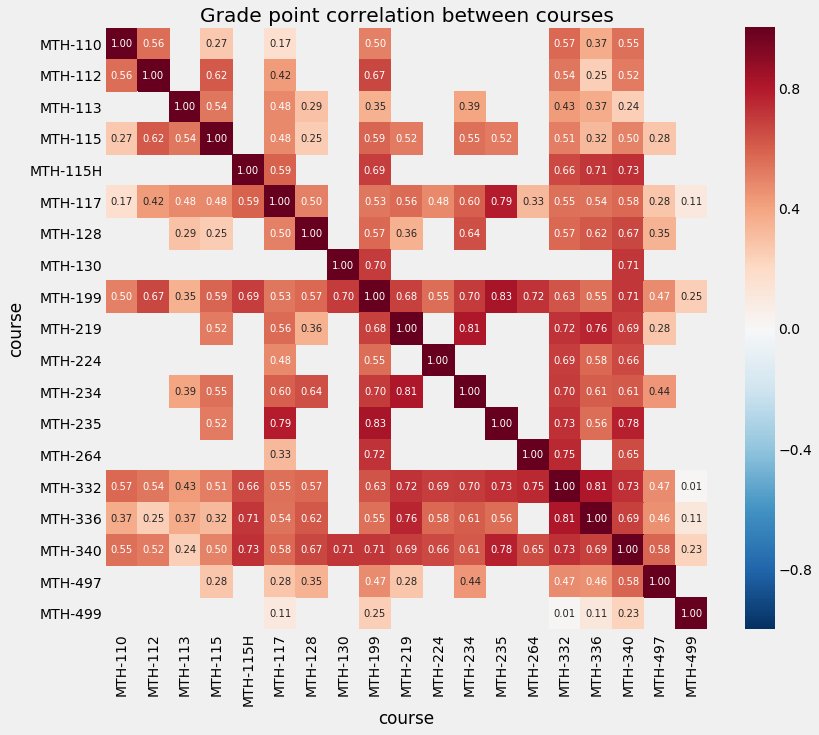

In [33]:
# Grade point correlation by course
min_count = 20    # exclude courses taken less than min_count times
min_periods = 20  # don't calculate correlation for course combinations 
                  # occuring less than min_periods

graph_data = (data.groupby('course')
                  .filter(lambda group: len(group) >= min_count)
                  .pivot_table('point', 'id', 'course', aggfunc='max')
                  .corr(min_periods=min_periods)
             )

fig = plt.figure(figsize=(12, 12))
ax = (sns.heatmap(graph_data, 
                  vmin=-1, vmax=1, center=0,
                  cmap='RdBu_r', cbar_kws={'shrink':0.86},
                  annot=True, fmt='.2f', annot_kws={'fontsize':10},
                  square=True
                )
     )

plt.title('Grade point correlation between courses')
plt.show()

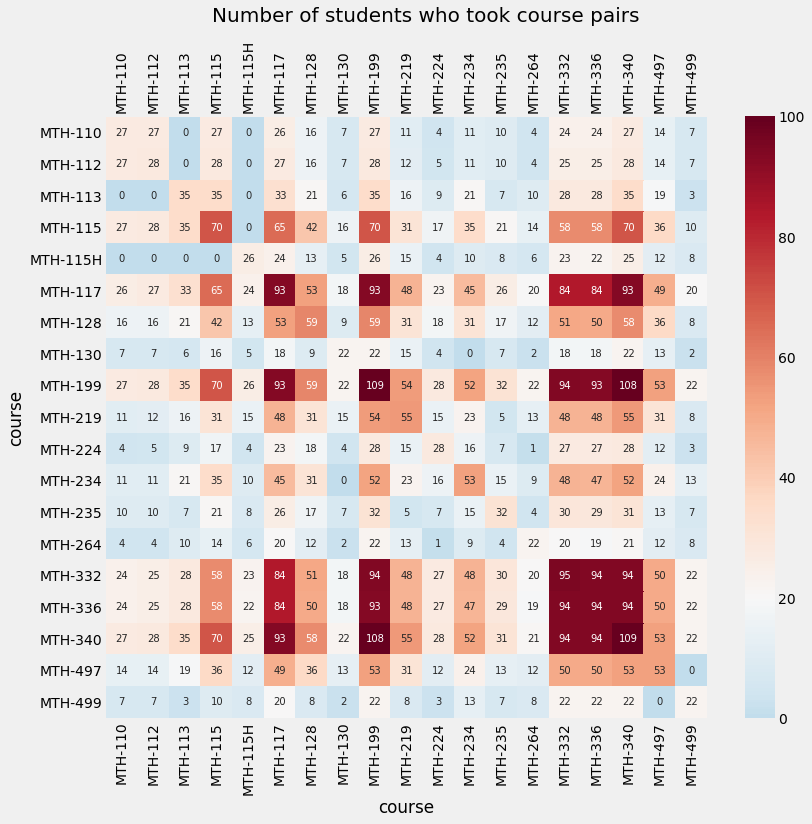

In [34]:
# Counts of times course pairs were taken by the same student
min_count = 20
corr_data = (data.groupby('course')
                 .filter(lambda group: len(group) >= min_count)
                 .pivot_table('point', 'id', 'course', aggfunc='max')
            )

pair_count = np.zeros((corr_data.shape[1], corr_data.shape[1]))
for index, row in pd.notnull(corr_data).iterrows():
    for i in range(len(row)):
        for j in range(i, len(row)):
            pair_count[i, j] += (int(row[i] and row[j]))
            if i != j:
                pair_count[j, i] += (int(row[i] and row[j]))

fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(pd.DataFrame(pair_count, index=corr_data.columns, 
                         columns=corr_data.columns),
                  cmap='RdBu_r', cbar_kws={'shrink':0.86},
                  vmin=0, vmax=100, center=20,
                  annot=True, fmt='.0f', annot_kws={'fontsize':10},
                  square=True
           )

ax.xaxis.set_tick_params(labeltop=True)
plt.xticks(rotation=90)
plt.suptitle('Number of students who took course pairs',  
             y=0.95, x=0.45, fontsize=20)
plt.show()

### Student grade by Course
* Can follow individual students, but might be too large to be useful
* Also somewhat sparse
  + including less courses makes reading easier, but reduces information 

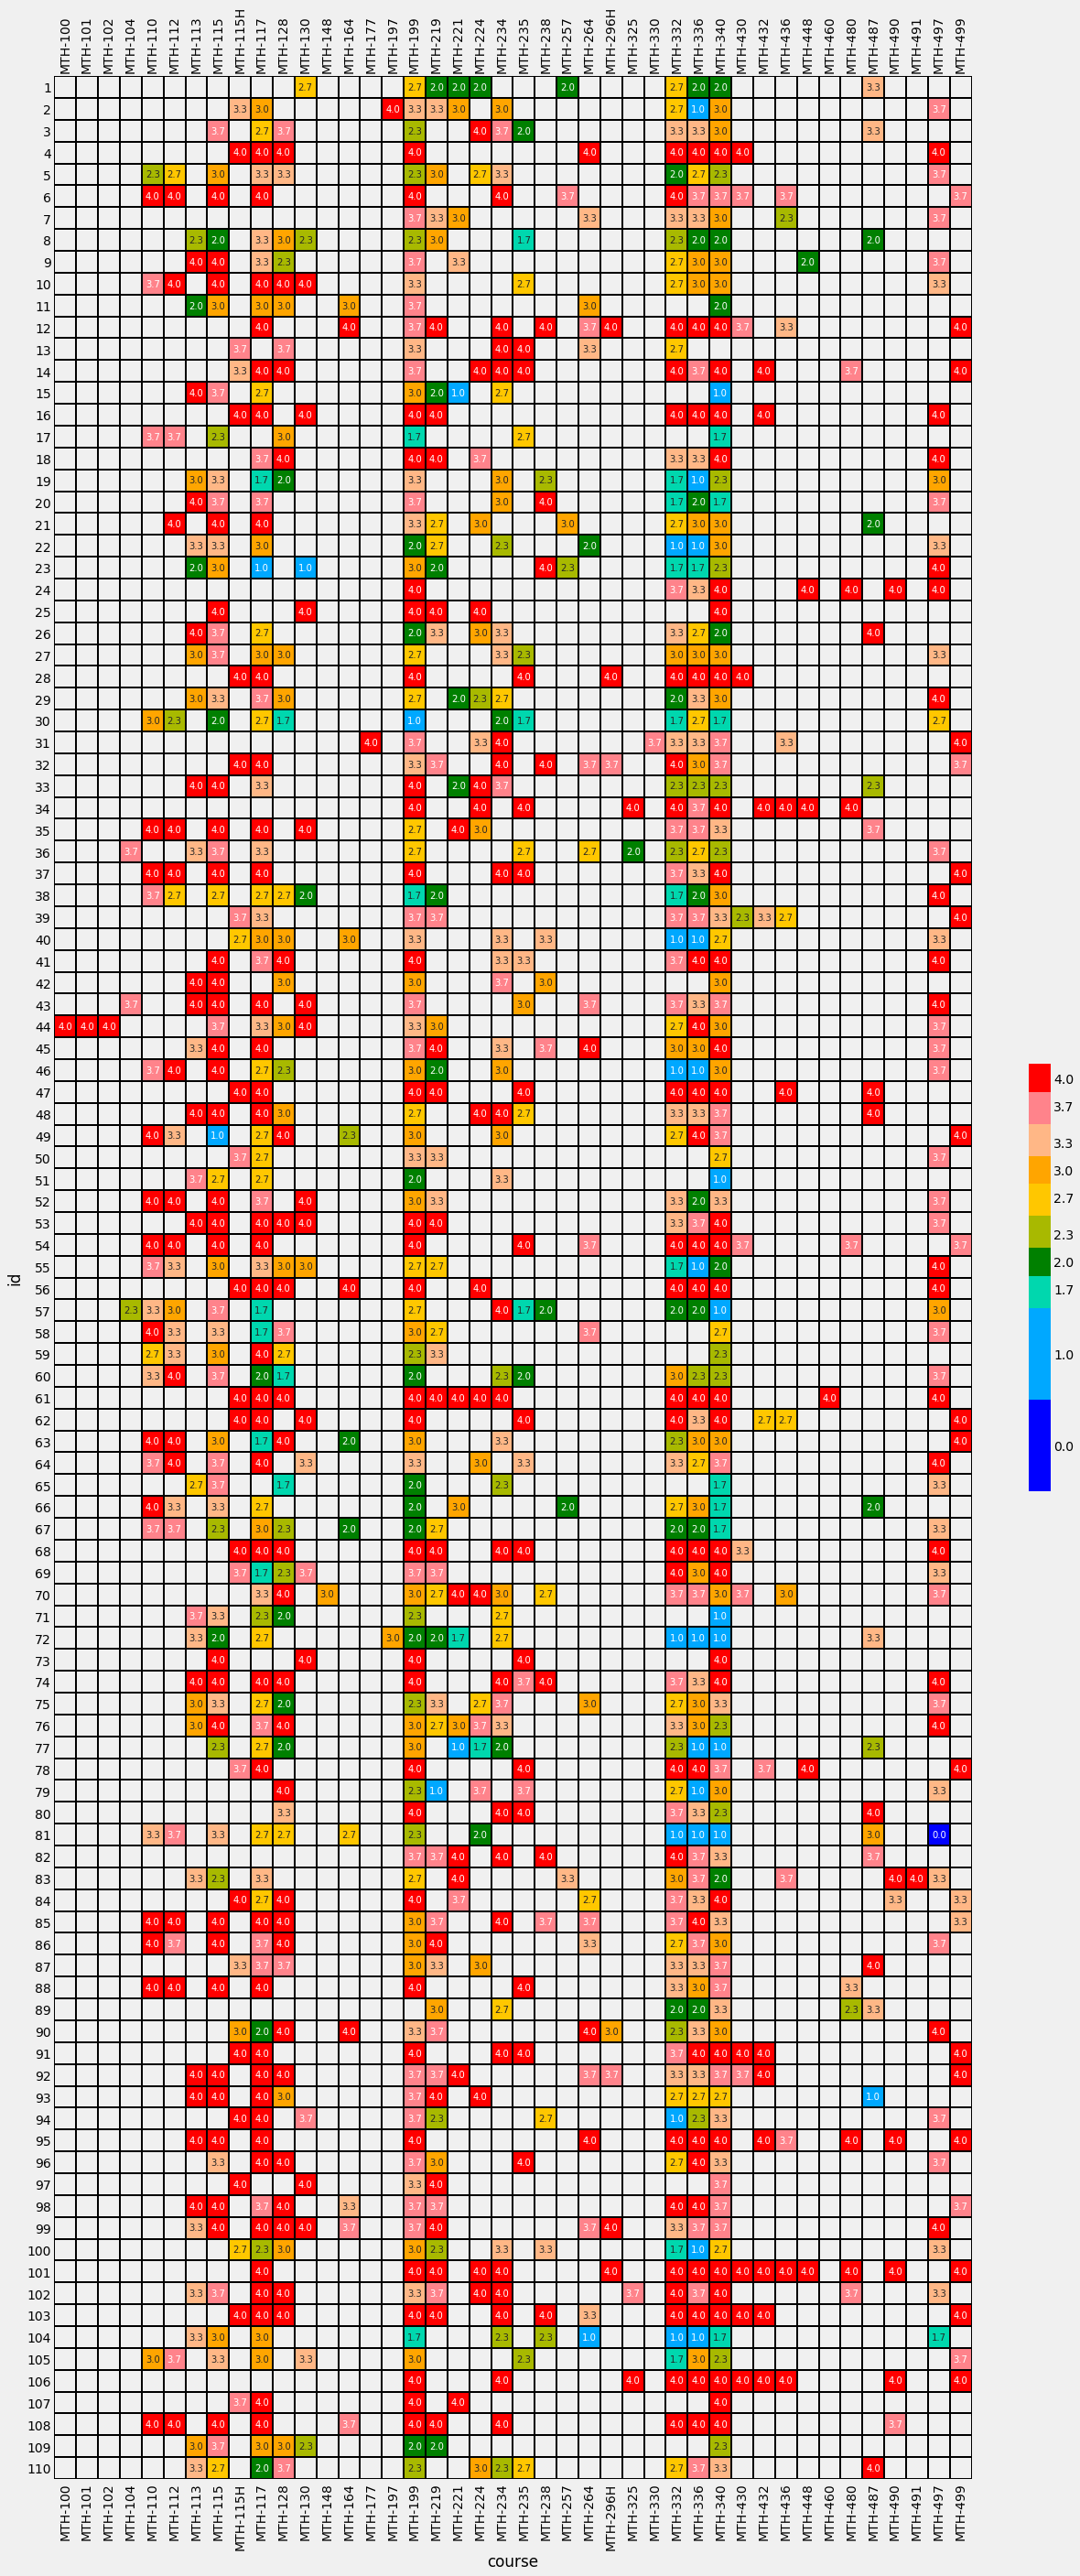

In [35]:
# Grades by student by course - showing all classes
min_count = 1    # exclude courses taken less than min_count times
include = ['MTH-100', 'MTH-101', 'MTH-102']  # include regardles of time taken

graph_data = (data.groupby('course')
                  .filter(lambda group: (len(group) >= min_count) | 
                                        (group.course.max() in include))
                  .pivot_table('point', 'id', 'course', aggfunc='max')
             )

include = graph_data.columns   # For use in graphing by class (next cell) 

fig = plt.figure(figsize=(20, 50))
colors = ['blue', 'cyan', 'green', 'gold', 'orange', 'pink', 'red']  
cmap = plt_colors.LinearSegmentedColormap.from_list('custom_cb', colors)
bounds=[-0.5, 0.5, 1.5, 1.85, 2.15, 2.5, 2.85, 3.15, 3.5, 3.85, 4.15]
norm = plt_colors.BoundaryNorm(bounds, cmap.N)

ax = (sns.heatmap(graph_data, 
                  vmin=0, vmax=4,
                  cmap=cmap,
                  cbar_kws={'shrink':0.16, 'cmap':cmap, 'norm':norm,
                            'ticks':point_rank,
                            'spacing':'proportional', 
                            'format':'%.1f'},
                  linewidth=1, linecolor='black',
                  annot=True, fmt='.1f', annot_kws={'fontsize':10},
                  square=True,
                  norm=norm
                )
     )

ax.xaxis.set_tick_params(labeltop=True)
plt.xticks(rotation=90)
plt.show()

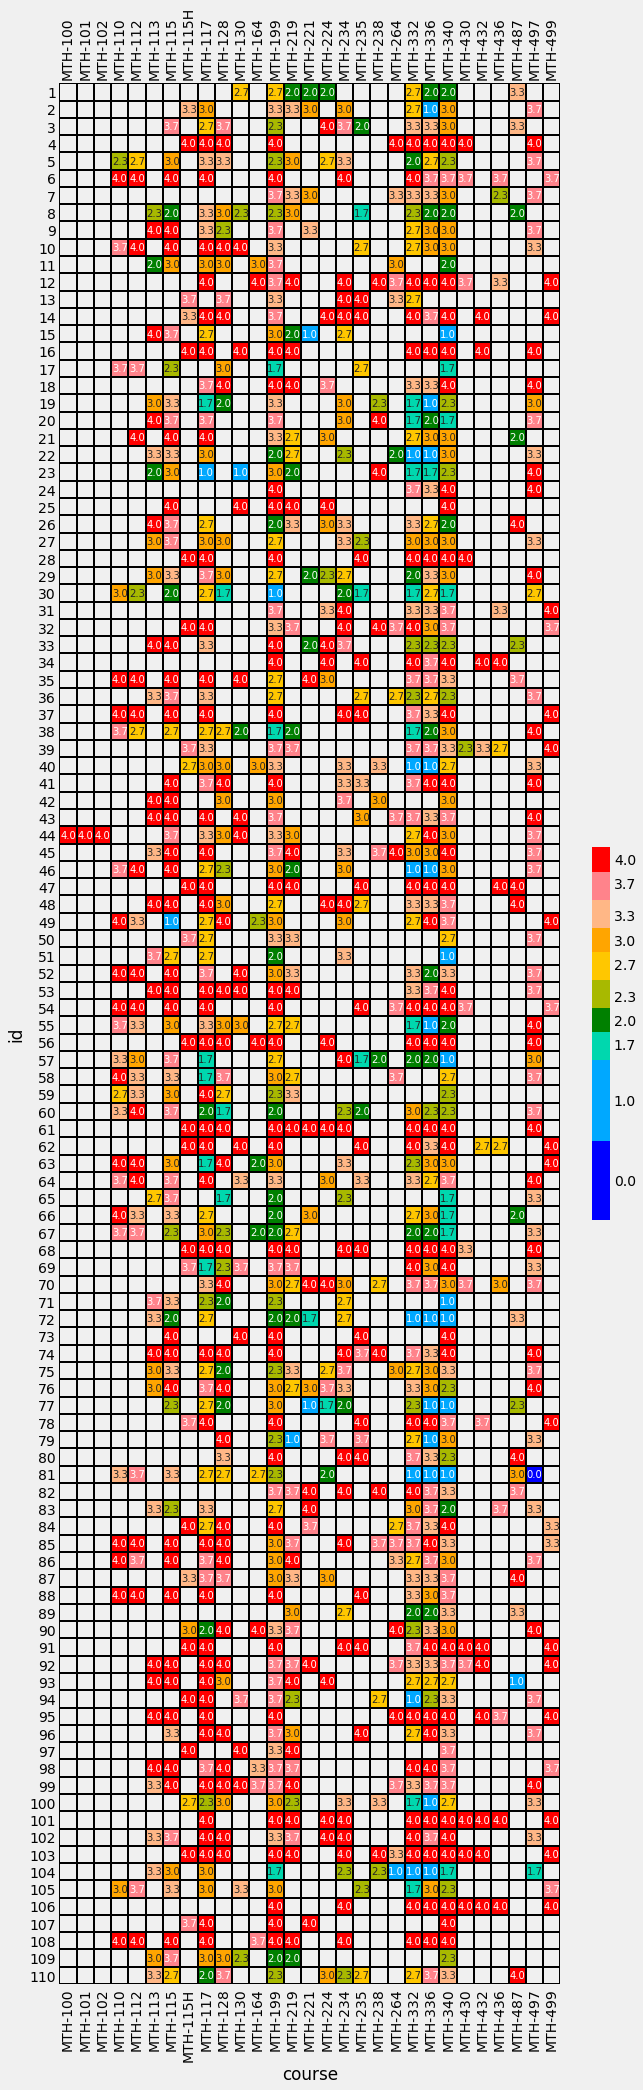

In [36]:
# Grades by student by course 
#   showing courses taken more at least 10 times across all class years
#   and MTH-100, 101 and 102 regardless
min_count = 10    # exclude courses taken less than min_count times
include = ['MTH-100', 'MTH-101', 'MTH-102']  # include regardles of time taken

graph_data = (data.groupby('course')
                  .filter(lambda group: (len(group) >= min_count) | 
                                        (group.course.max() in include))
                  .pivot_table('point', 'id', 'course', aggfunc='max')
             )

include = graph_data.columns   # For use in graphing by class (next cell) 

fig = plt.figure(figsize=(10, 40))
colors = ['blue', 'cyan', 'green', 'gold', 'orange', 'pink', 'red']  
cmap = plt_colors.LinearSegmentedColormap.from_list('custom_cb', colors)
bounds=[-0.5, 0.5, 1.5, 1.85, 2.15, 2.5, 2.85, 3.15, 3.5, 3.85, 4.15]
norm = plt_colors.BoundaryNorm(bounds, cmap.N)

ax = (sns.heatmap(graph_data, 
                  vmin=0, vmax=4,
                  cmap=cmap,
                  cbar_kws={'shrink':0.16, 'cmap':cmap, 'norm':norm,
                            'ticks':point_rank,
                            'spacing':'proportional', 
                            'format':'%.1f'},
                  linewidth=1, linecolor='black',
                  annot=True, fmt='.1f', annot_kws={'fontsize':10},
                  square=True,
                  norm=norm
                )
     )

ax.xaxis.set_tick_params(labeltop=True)
plt.xticks(rotation=90)
plt.show()

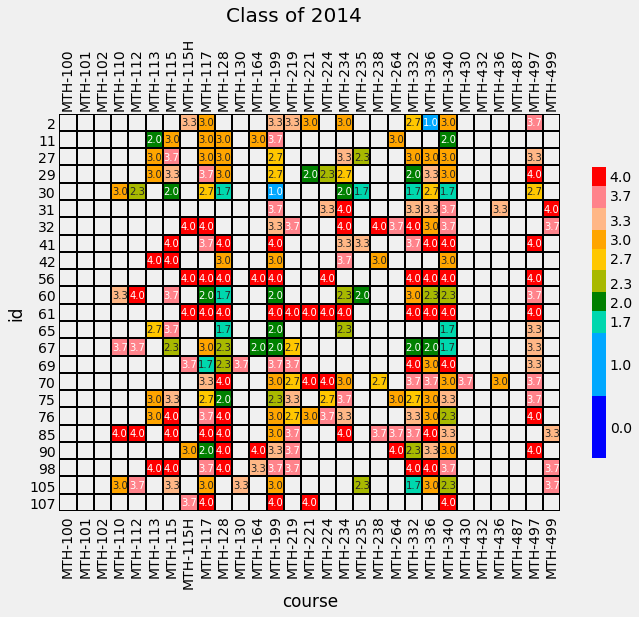

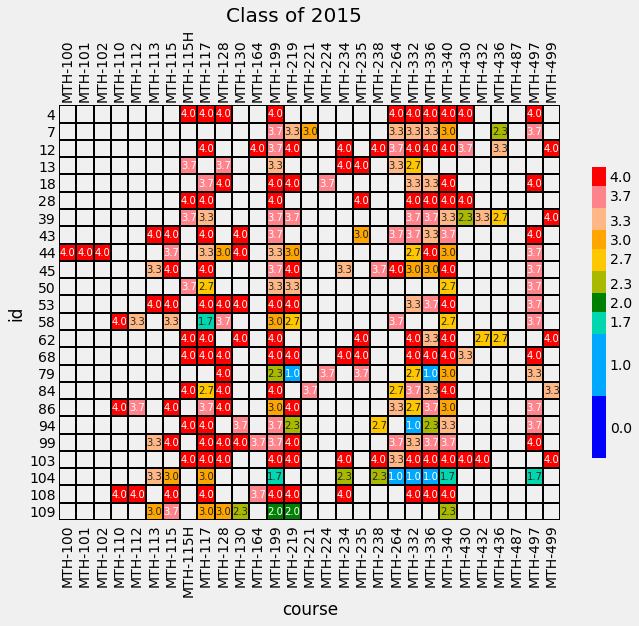

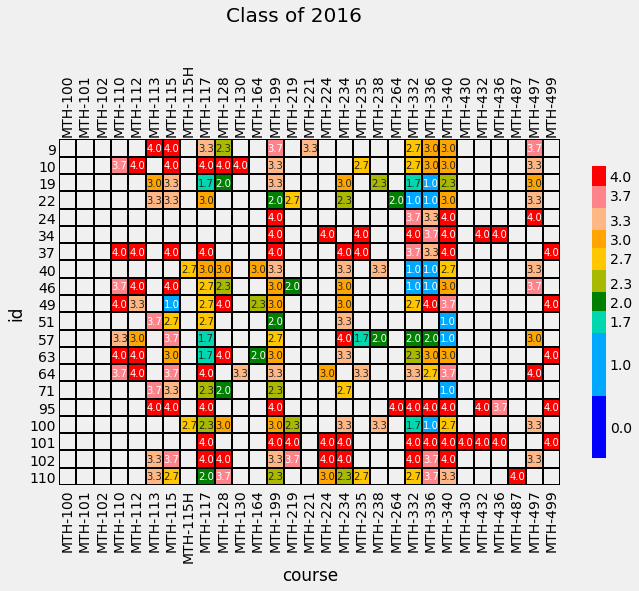

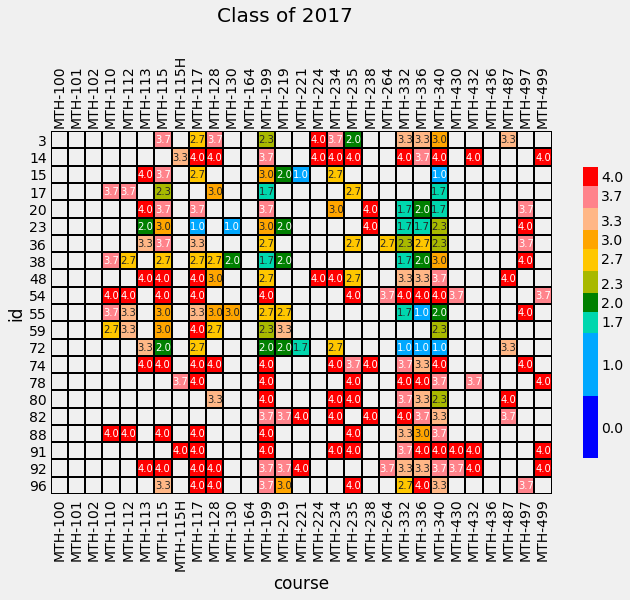

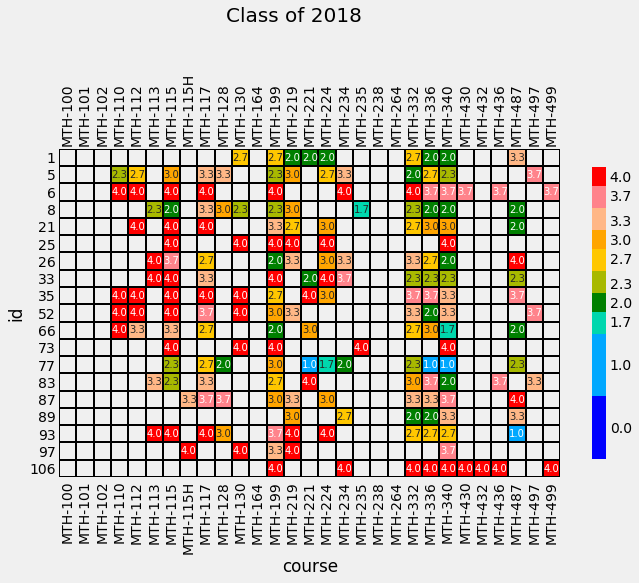

In [37]:
# Grades by student by course by class
#   showing courses taken at least 10 times across all years
#   and MTH-100, 101 and 102 regardless
class_years = [2014, 2015, 2016, 2017, 2018]

graph_data = (data.groupby('course')
                  .filter(lambda group: (group.course.max() in include))
                  .pivot_table('point', 'id', 'course', aggfunc='max',
                                dropna=False))

for class_year in class_years:
    class_ids = info.loc[info.class_year == class_year].id.values
    graph_data_year = (graph_data.loc[graph_data.index.isin(class_ids)])

    fig = plt.figure(figsize=(10, 10))
    colors = ['blue', 'cyan', 'green', 'gold', 'orange', 'pink', 'red']  
    cmap = plt_colors.LinearSegmentedColormap.from_list('custom_cb', colors)
    bounds=[-0.5, 0.5, 1.5, 1.85, 2.15, 2.5, 2.85, 3.15, 3.5, 3.85, 4.15]
    norm = plt_colors.BoundaryNorm(bounds, cmap.N)

    ax = (sns.heatmap(graph_data_year, 
                      vmin=0, vmax=4,
                      cmap=cmap,
                      cbar_kws={'shrink':0.5, 'cmap':cmap, 'norm':norm,
                                'ticks':point_rank,
                                'spacing':'proportional', 
                                'format':'%.1f'},
                      linewidth=1, linecolor='black',
                      annot=True, fmt='.1f', annot_kws={'fontsize':10},
                      square=True,
                      norm=norm
                    )
         )

    ax.xaxis.set_tick_params(labeltop=True)
    plt.xticks(rotation=90)
    plt.suptitle('Class of {0}'.format(class_year), ha='right', size=20, y=0.9)
    plt.show()